# Train With Colbert Q & A

In [1]:
#pip install bitsandbytes

In [2]:
#!mamba uninstall bitsandbytes -c conda-forge -y

In [3]:
import os
project_name = "Science Exam - Kaggle"
run_name = "new_prompt_sci_deb_xl_v2"

config = {
    'max_words': 100,
    'nbits': 1,
    'colbert_indexer_version': 6,
    'hf_model_id': 'microsoft/deberta-v2-xlarge',
    'deberta_max_length': 512,
    'large_train_deduped': False, # if this is True the individual ones below are skipped
    'use_train_daniel': True,
    'use_osmu_sci_6k': True,
    'use_osmu_21k': False,
    'use_mgoksu_13k': True,
    'use_gigkpea_3k': True,
    'n_extra_test_rows' : 300,
    'lr_layer_factor': None, # set to an int to layer, None to not layer, need to be adapted to work with 8-bit Adam
    'learning_rate': 1e-5,
    'num_train_epochs': 1,
    '8_bit_adam': True
}

from transformers import TrainingArguments, IntervalStrategy
from pathlib import Path

output_path = Path('./checkpoints')
training_args = TrainingArguments(
    learning_rate=config['learning_rate'],
    num_train_epochs=config['num_train_epochs'],
    # fp16=True,
    # warmup_ratio=0.5,
    weight_decay=0,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=6,
    gradient_accumulation_steps=4, # number of batches to sum up gradient for
    gradient_checkpointing=True,
    # optim='adafactor',
    evaluation_strategy = IntervalStrategy.STEPS,
    logging_steps=10,
    eval_steps=100,
    save_strategy='no',
    # save_steps=20000,
    report_to='wandb',
    output_dir=str(output_path)
)

In [4]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'garbage_collection_threshold:0.6,max_split_size_mb:128'

In [5]:
import os
import glob
import gc
import polars as pl
import polars.selectors as cs
import pandas as pd
import pyarrow as pa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from dataclasses import dataclass
from typing import Optional, Union
from scipy.special import softmax


from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert.data import Queries
from colbert import Indexer, Searcher

import wandb

import torch
from torch import nn

import evaluate
from transformers import AutoTokenizer, AutoModelForMultipleChoice, Trainer, \
                        get_linear_schedule_with_warmup
from transformers.integrations import WandbCallback
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from transformers.utils.notebook import NotebookProgressCallback
from transformers.trainer_pt_utils import get_parameter_names
from datasets import Dataset # HuggingFace
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

import bitsandbytes as bnb

In [6]:
pl.Config(fmt_str_lengths=2000);

In [7]:
#!conda install -c conda-forge faiss-gpu -y

In [8]:
n_extra_test = config['n_extra_test_rows']
train_sets = []
test_sets = {}

test = pl.read_csv('data/train.csv')
test = test.rename({'prompt': 'question'})
test = test.drop(columns="id")
test_sets['test'] = test


def read_training_files(file_paths, test_name):
    if type(file_paths) == str:
        file_paths = [file_paths]
        
    if file_paths[0].endswith('.parquet'):
        train_raw = pl.concat(
            [pl.read_parquet(file) for file in file_paths]
        )
    elif file_paths[0].endswith('.csv'):
        train_raw = pl.concat(
            [pl.read_csv(file) for file in file_paths]
        )
    
    if 'prompt' in train_raw.columns:
        train_raw = train_raw.rename({'prompt': 'question'})
    train_cols = ['question', 'A', 'C', 'B', 'D', 'E', 'answer']
    train_raw = train_raw[train_cols]
    train_raw = train_raw.select(pl.all().fill_null('N/A'))
    
    test_split = train_raw[train_raw.shape[0] - n_extra_test:]
    train = train_raw[:train_raw.shape[0] - n_extra_test]
    
    train_sets.append(train)
    test_sets[test_name] = test_split

if config['large_train_deduped']:
    read_training_files('./data/large_train_dedupe.parquet', 'combined')
else:        
    if config['use_train_daniel']:
        read_training_files('./data/train_dedupe/daniel.parquet', 'daniel')

    if config['use_osmu_sci_6k']:
        read_training_files('./data/train_dedupe/osmu_sci_6k.parquet', 'osmu_sci_6k')
    if config['use_osmu_21k']:
        read_training_files([
            './data/train_dedupe/osmu_15k.parquet',
            './data/train_dedupe/osmu_5_9k.parquet'
            ], 'osmu_21k')

    if config['use_mgoksu_13k']:
        read_training_files('./data/train_dedupe/mgoksu.parquet', 'mgoksu')

    if config['use_gigkpea_3k']:
        read_training_files('./data/train_dedupe/gigkpea.parquet', 'gigkpea')

train = pl.concat(train_sets)
f'{train.shape[0]:,}'

'32,625'

## Retrieve Wiki Context via ColBERT

In [9]:
max_words = config['max_words']
nbits = config['nbits']
colbert_indexer_version = config['colbert_indexer_version']
colbert_path = Path(f'./data/colbert_max_words_{max_words}_nbits_{nbits}-v{colbert_indexer_version}')
wiki_passages = pl.read_parquet(colbert_path/f'wiki_passages.parquet')
wiki_passages.columns

['passage_id',
 'section_id',
 'title',
 'section_title',
 'section_index',
 'passage_text',
 'title_section_rank',
 'section_passage_num',
 'titled_passage',
 'word_count']

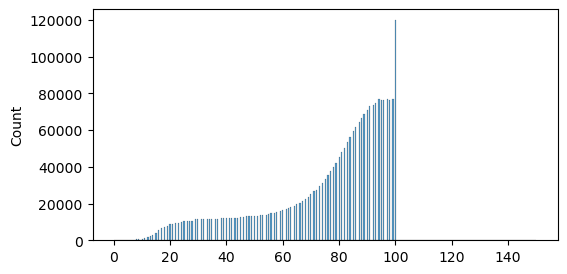

In [10]:
word_counts = wiki_passages['titled_passage'].str.split(' ').list.lengths()
word_counts.max()
plt.figure(figsize=[6,3])
sns.histplot(word_counts, binrange=[0, max_words + 50]);

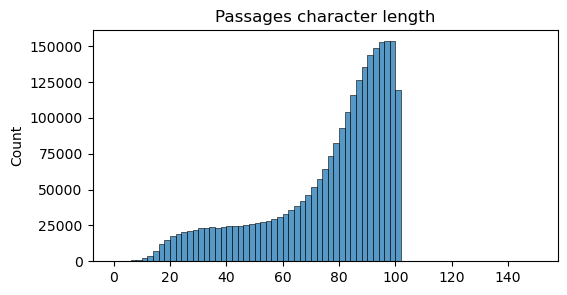

In [11]:
plt.figure(figsize=[6,3])
sns.histplot(word_counts, binrange=[0, 150], bins=75)
plt.title('Passages character length');

In [12]:
n_results_per_question = 3

#doc_maxlen = 160 # 512   # lenght in tokens
#dim = 128 # 128 is max for BERT

checkpoint = './checkpoints/colbertv2.0'

indexer_name = f'colbert_wiki_indexer'
#os.environ['COLBERT_LOAD_TORCH_EXTENSION_VERBOSE'] = 'True'

colbert_config = ColBERTConfig(
    doc_maxlen=config['deberta_max_length'],
    nbits=nbits
    #dim=dim
)

In [13]:
a_to_e = ['A', 'B', 'C', 'D', 'E']
score_col_prefix = 'answer_passage_score_'
ctx_id_prefix = 'passage_id_'
num_answer_ctx_cols = 2

def add_answer_colbert_context(data, searcher):
    for letter in a_to_e:
        print(f'\n{letter=}')
        gc.collect()
        answer_queries = data.with_columns((pl.col('question') + ' ' + pl.col(letter)).str.replace_all('\n', ' ').alias('q_and_a'))
        answer_queries = answer_queries.with_row_count('qid')[['qid', 'q_and_a']]
        
        queries_file = './data/wiki_queries.tsv'
        answer_queries.write_csv(queries_file, separator='\t', has_header=False)

        col_a_queries = Queries(queries_file)
       
        ranking = searcher.search_all(col_a_queries, k=n_results_per_question)
        torch.cuda.empty_cache()

        ranking = pl.DataFrame([(id, tup_list) for id, tup_list in ranking.items()])
        answer_passage_ids = [ranking['column_1'].list.get(i).list.get(0) for i in range(num_answer_ctx_cols)]
        answer_scores = [ranking['column_1'].list.get(i).list.get(2) for i in range(num_answer_ctx_cols)]

        for i in range(num_answer_ctx_cols): 
            id_col_name = f'{ctx_id_prefix}{letter}_{i+1}'
            score_col_name = f'{score_col_prefix}{letter}_{i+1}'
            data = data.with_columns(**{
                id_col_name: answer_passage_ids[i].cast(pl.UInt32),
                score_col_name: answer_scores[i]
            })

            passages = wiki_passages[['passage_id', 'titled_passage']]
            data = data.join(passages, how='left', left_on=id_col_name, right_on='passage_id', validate='m:1', suffix=f'_{letter}_{i+1}')
    
    # if the job above already created the a colum titled passage, the first one will already be called titled_passage_A2
    if 'titled_passage_A' not in data.columns:
        data = data.rename({'titled_passage': 'titled_passage_A_1'})
    return data
    
    
# TODO make it possible to use answer context for multiple letters
def add_best_answers(data):
    best_answer_matches = []
    second_answer_context = []
    best_answer_letters = []
    best_answer_ids = []
    second_answer_ids = []
    highscores = []
    for row in data.iter_rows(named=True):
        highest_score = 0
        highscore_letter = None
        best_answer_id = None
        for letter in a_to_e:
            score_col_name = f'{score_col_prefix}{letter}_1'
            if row[score_col_name] > highest_score:
                highest_score = row[score_col_name]
                highscore_letter = letter
                best_answer_id = row[f'{ctx_id_prefix}{letter}_1']
             
        second_score = 0
        second_letter = None
        second_num = None
        second_answer_id = None
        # print(highscore_letter, best_answer_id)
        for letter in a_to_e:
            for ctx_num in range(num_answer_ctx_cols):              
                if letter == highscore_letter and ctx_num == 0:
                    continue
                score_col_name = f'{score_col_prefix}{letter}_{ctx_num+1}'
                current_ctx_id = row[f'{ctx_id_prefix}{letter}_{ctx_num+1}']
                # print(letter, ctx_num, current_ctx_id)
                if row[score_col_name] > second_score and current_ctx_id != best_answer_id:
                    second_score = row[score_col_name]
                    second_letter = letter
                    second_num = ctx_num+1
                    second_answer_id = row[f'{ctx_id_prefix}{letter}_{second_num}']

        passage_col_name = f'titled_passage_{highscore_letter}_1'
        best_answer_matches.append(row[passage_col_name])
        passage_col_2_name = f'titled_passage_{second_letter}_{second_num}'
        second_answer_context.append(row[passage_col_2_name])
        best_answer_letters.append(highscore_letter)
        highscores.append(highest_score)
        best_answer_ids.append(best_answer_id)
        second_answer_ids.append(second_answer_id)

    return data.with_columns(best_answer_match=pl.Series(best_answer_matches),
                             second_answer_context=pl.Series(second_answer_context),
                             answer_score=pl.Series(highscores),
                             best_answer_letter=pl.Series(best_answer_letters),
                             best_answer_id=pl.Series(best_answer_ids),
                             second_answer_id=pl.Series(second_answer_ids))

In [14]:
def add_q_colbert_context(data, searcher):
    num_ctx_cols = 1
    gc.collect()
    queries = data.with_row_count('qid')[['qid', 'question']]
    queries = queries.with_columns(pl.col('question').str.replace_all('\n', ' ')) 
    queries_file = './data/wiki_queries.tsv'
    queries.write_csv(queries_file, separator='\t', has_header=False)

    c_queries = Queries(queries_file)

    ranking = searcher.search_all(c_queries, k=n_results_per_question)
    torch.cuda.empty_cache()

    ranking = pl.DataFrame([(id, tup_list[0]) for id, tup_list in ranking.items()])
    colbert_passage_ids = []
    for row_idx in range(ranking.shape[0]):
        for i in range(n_results_per_question):
            passage_id = ranking[row_idx]['column_1'].list.get(i).cast(pl.UInt32).item()
            if passage_id == data[row_idx, 'best_answer_id'] or \
                passage_id == data[row_idx, 'second_answer_id']:
                if i < 2:
                    continue
                else:
                    raise Exception('No unique passage_id found for question.')
            else:
                colbert_passage_ids.append(passage_id)
                break     
    
    
    passages = wiki_passages[['passage_id', 'titled_passage']]
    data_p = data.with_columns(pl.Series('question_ctx_id', colbert_passage_ids, dtype=pl.UInt32))
    for i in range(num_ctx_cols):
        data_p = data_p.join(passages, how='left', left_on=f'question_ctx_id', right_on='passage_id', validate='m:1', suffix=f'_{i+1}')
    data_p = data_p.rename({'titled_passage': 'question_ctx'}) 
    return data_p

In [15]:
rerun = False

enriched_cache_path = Path(f"./data/qa_context_{max_words}_v_{config['colbert_indexer_version']}")
os.makedirs(enriched_cache_path, exist_ok=True)


def create_or_get_searcher(searcher):
    if searcher is None:
        searcher = Searcher(index=indexer_name, 
                            config=colbert_config,
                            collection=str(colbert_path/f'wiki_passages.tsv'))
    return searcher

def cached_add_q_colbert_context(data, file_name):
    file_path = enriched_cache_path/f'{file_name}.parquet'
    searcher = None
    if file_path.exists() and not rerun:
        return pl.read_parquet(file_path)
    else:   
        searcher = create_or_get_searcher(searcher)
        with_context = data
        with_context = add_answer_colbert_context(with_context, searcher)
        with_context = add_best_answers(with_context)
        with_context.write_parquet('./data/with_context_temp.parquet')
        with_context = add_q_colbert_context(with_context, searcher)
        with_context.write_parquet(file_path)
        return with_context
    

train_file_name = f"train_d_{config['use_train_daniel']}_o21_{config['use_osmu_21k']}\
_osci_{config['use_osmu_sci_6k']}_mgoksu_{config['use_mgoksu_13k']}_gigkpea_{config['use_gigkpea_3k']}"

with Run().context(RunConfig(nranks=1, index_root=str(colbert_path))):    
    train_ctx = cached_add_q_colbert_context(train, train_file_name)
    test_sets_ctx = {}
    for name, data in test_sets.items():
        test_sets_ctx[name] = cached_add_q_colbert_context(data, name)

In [16]:
# test_osmu_p['passage_text'].str.split(' ').list.lengths().max()

## Prepare Train and Test for DeBERTa

In [17]:
tokenizer = AutoTokenizer.from_pretrained(config['hf_model_id'])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [18]:
max_length = config['deberta_max_length']

option_to_index = {option: idx for idx, option in enumerate('ABCDE')}
index_to_option = {v: k for k,v in option_to_index.items()}

@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: PreTrainedTokenizerBase
    max_length: Optional[int] = None

    
    def __call__(self, input_batch):
        # input_batch is list of samples, choices, tokens
        additional_cols = set(input_batch[0].keys()) - set(['input_ids', 'token_type_ids', 'attention_mask', 'label'])
        if len(additional_cols) > 0:
            print(f'{additional_cols=}')
        
        label_name = None
        if 'label' in input_batch[0].keys():
            label_name = 'label' 
            labels = [feature.pop(label_name) for feature in input_batch]
        batch_size = len(input_batch)
        num_choices = len(input_batch[0]['input_ids'])
        flattened_input = [
            [{k: v[i] for k, v in sample.items()} for i in range(num_choices)] for sample in input_batch
        ]
        flattened_input = sum(flattened_input, [])
        
        batch = self.tokenizer.pad(
            flattened_input,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt',
        )
        
        # batch.shape = (n_samples, n_choices, n_tokens)
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        if label_name is not None:
            batch['labels'] = torch.tensor(labels, dtype=torch.int64)
        #print(np.array(batch['input_ids']).shape)
        return batch

In [19]:
def preprocess(example):
    # adding the wikipedia page as context for the question by adding it after a [SEP] token to the question.
#     first_sentence = [f"""{example['question']}
# [SEP]{example['best_answer_match']}

# [SEP]{example['question_ctx']}
# """] * 5
# [SEP]{example['best_answer_letter']}
    # The N/A workaround can be removed after rerunning the ColBERT search above
    first_sentence = [f"""[CLS] {example['best_answer_match']} [SEP] {example['second_answer_context']} [SEP] {example['question_ctx']}"""] * 5
    second_sentences = []
    for option in 'ABCDE':
        answer = example[option]
        if answer is not None:
            second_sentences.append(" #### " + example["question"] + " [SEP] " + example[option] + " [SEP]")
        else:
            second_sentences.append('N/A')
    try:
        tokenized_example = tokenizer(first_sentence, second_sentences, truncation='longest_first', max_length=max_length)
    except:
        print(first_sentence, second_sentences)
        raise
    if 'answer' in example.keys():
        tokenized_example['label'] = option_to_index[example['answer']]
    
    return tokenized_example

def tokenized_dataset(data):
    columns_to_keep = set(['input_ids', 'token_type_ids', 'attention_mask', 'label'])
    dataset = Dataset.from_pandas(data.to_pandas(), preserve_index=False)
    col_to_remove = set(data.columns) - columns_to_keep
    tokenized = dataset.map(preprocess, remove_columns=col_to_remove)
    return tokenized

In [20]:
tokenized_train = tokenized_dataset(train_ctx)
eval_datasets = {}
for name, data in test_sets_ctx.items():
    eval_datasets[name] = tokenized_dataset(data)

Map:   0%|          | 0/32625 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

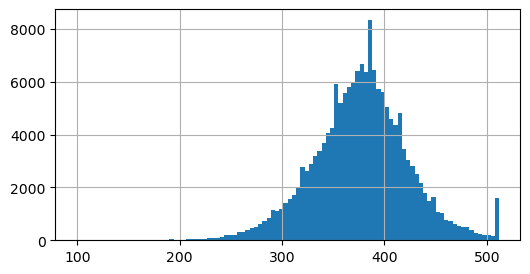

In [21]:
def plot_length_hist(tokenized_data):
    length_list = []
    for sample in tokenized_data['input_ids']:
        for option in sample:
            length_list.append(len(option))

    plt.figure(figsize=[6,3])
    pd.Series(length_list).hist(bins=100)
    
plot_length_hist(tokenized_train)

## Train DeBERTa

In [22]:
def precision_at_k(predictions, actuals, k=3):        
    if isinstance(actuals, list):
        actuals = np.array(actuals)
        
    found_at = np.where(predictions == actuals.reshape(-1, 1))
    # found_at is a tuple with the array of found indices in the second position
    score = 1 / (1 + found_at[1])
    score[score < 1/k] = 0
    return score

def mean_avg_precision_at_k(predictions, actual, k=3):
    n = predictions.shape[0]
    row_precision = precision_at_k(predictions, actual)
    return row_precision.sum()/n

acc_metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.flip(predictions.argsort(axis=1), axis=1)
    accuracy = acc_metric.compute(predictions=predictions[:,0], references=labels)['accuracy']
    map_at_3 = mean_avg_precision_at_k(predictions, labels)
    return {
        'accuracy': accuracy,
        'map_at_3': round(map_at_3, 3)
    }

In [23]:
retrain = True

if not output_path.exists() or retrain:
    wandb.init(
        project=project_name,
        name=run_name,
        job_type='train',
        config=config
        # group="bert"
    )
       
    torch.cuda.empty_cache()
    model = AutoModelForMultipleChoice.from_pretrained(config['hf_model_id'])

    total_steps = len(tokenized_train) * training_args.num_train_epochs // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps) 
    
    if config['8_bit_adam']:
        decay_parameters = get_parameter_names(model, [nn.LayerNorm])
        decay_parameters = [name for name in decay_parameters if "bias" not in name]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if n in decay_parameters],
                "weight_decay": training_args.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if n not in decay_parameters],
                "weight_decay": 0.0,
            },
        ]
        optimizer_kwargs = {
            "betas": (training_args.adam_beta1, training_args.adam_beta2),
            "eps": training_args.adam_epsilon,
        }
        optimizer_kwargs["lr"] = training_args.learning_rate
        optimizer = bnb.optim.Adam8bit(
            optimizer_grouped_parameters,
            betas=(training_args.adam_beta1, training_args.adam_beta2),
            eps=training_args.adam_epsilon,
            lr=training_args.learning_rate,
        )
        max_lr=training_args.learning_rate
    elif type(config['lr_layer_factor']) == int:
        factor = config['lr_layer_factor']
        base_lr = training_args.learning_rate
        
        embedding_lr = base_lr / factor**4
        early_layers_lr = base_lr / factor**3
        middle_layers_lr = base_lr / factor**2
        late_layers_lr = base_lr / factor
        classifier_lr = base_lr

        optimizer_grouped_parameters = [
            {'params': model.deberta.embeddings.parameters()},
            {'params': model.deberta.encoder.layer[:8].parameters()},
            {'params': model.deberta.encoder.layer[8:16].parameters()},
            {'params': model.deberta.encoder.layer[16:].parameters()},
            {'params': model.classifier.parameters()},
        ]
        optimizer = AdamW(optimizer_grouped_parameters,
                          weight_decay=training_args.weight_decay)
        max_lr = [base_lr / config['lr_layer_factor']**i for i in range(5,0,-1)]
        
    else:
        optimizer = AdamW(model.parameters(),
                          lr=training_args.learning_rate,
                          weight_decay=training_args.weight_decay)
        max_lr=training_args.learning_rate
    
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps)
      
    #warmup_steps = int(total_steps * training_args.warmup_ratio)
    #scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    
    trainer = Trainer(
        model=model,
        args=training_args,
        tokenizer=tokenizer,
        data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer, max_length=600),
        train_dataset=tokenized_train,
        eval_dataset=eval_datasets,
        compute_metrics=compute_metrics,
        optimizers=(optimizer, scheduler)
    )

    # needed when there are multiple eval datasets
    trainer.remove_callback(NotebookProgressCallback)
    trainer.train()
    # wandb.config.update(config)
    wandb.finish()
    trainer.save_model(output_path/run_name)
else:
    model = AutoModelForMultipleChoice.from_pretrained(output_path/run_name)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: datadan. Use `wandb login --relogin` to force relogin


Some weights of DebertaV2ForMultipleChoice were not initialized from the model checkpoint at microsoft/deberta-v2-xlarge and are newly initialized: ['classifier.bias', 'pooler.dense.weight', 'pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/daniel/mambaforge/envs/pytorch/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/daniel_accuracy,▁▁▁▇████████████████
eval/daniel_loss,███▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/daniel_map_at_3,▁▁▂▇████████████████
eval/daniel_runtime,▄▄▄▂▅▃▄▂▄▃▅▄▁▅▇▅▇▇█▆
eval/daniel_samples_per_second,▅▅▄▇▄▆▅▇▄▆▄▅█▄▂▄▂▂▁▃
eval/daniel_steps_per_second,▆▆▆█▃▆▆█▆▆▆▆█▃▃▃▃▃▁▃
eval/gigkpea_accuracy,▂▂▁▅▆▆▇▇▇▇██████████
eval/gigkpea_loss,▇▇██▄▄▂▄▂▂▂▁▂▁▁▁▁▁▁▁
eval/gigkpea_map_at_3,▂▂▁▅▆▇▇▇▇███████████
eval/gigkpea_runtime,▂▁▂▂▄▁▄▂▂▃▃▄▄▃▃▃▂▅▃█
eval/gigkpea_samples_per_second,▇█▇▇▅█▅▇▇▆▆▅▅▆▆▆▇▄▆▁


## Predict Test Set

In [24]:
trainer = Trainer(
    model=model,
    data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer, max_length=600),
)

In [25]:
test_sets_ctx.keys()

dict_keys(['test', 'daniel', 'osmu_sci_6k', 'mgoksu', 'gigkpea'])

In [26]:
def predict_testset(test_with_passages, tokenized_testset):
    test_logits = trainer.predict(tokenized_testset).predictions
    test_preds = np.argsort(-test_logits, 1)
    test_letters = np.array(list('ABCDE'))[test_preds]
    test_letters = pl.Series(test_letters[:,:3]).list.join(' ')

    return test_with_passages.with_columns(all_prediction=test_letters, prediction=test_letters.str.slice(0,1))

In [27]:
with_pred = {}
for test_name in test_sets_ctx.keys():
    with_pred[test_name] = predict_testset(test_sets_ctx[test_name], eval_datasets[test_name])

In [28]:
folder_path = Path(f'./data/output/{run_name}')
os.makedirs(folder_path, exist_ok=True)
for test_name in test_sets_ctx.keys():
    file_path = folder_path/f'{test_name}.parquet'
    with_pred[test_name].write_parquet(file_path)
    print(file_path)

data/output/new_prompt_sci_deb_xl_v2/test.parquet
data/output/new_prompt_sci_deb_xl_v2/daniel.parquet
data/output/new_prompt_sci_deb_xl_v2/osmu_sci_6k.parquet
data/output/new_prompt_sci_deb_xl_v2/mgoksu.parquet
data/output/new_prompt_sci_deb_xl_v2/gigkpea.parquet


### Osmu data notes
0. Based on the wikipedia_excerpt, the wrong answer is marked as correct.

In [29]:
wiki_passages.filter(pl.col('title').str.contains('chloro'))

passage_id,section_id,title,section_title,section_index,passage_text,title_section_rank,section_passage_num,titled_passage,word_count
u32,u32,str,str,i64,str,u32,u32,str,u32
4710,1844,"""Tetrachloronickelate""","""History""",1,"""The blue colour due to the tetrachloronickelate ion was first observed in 1944 when Remy and Meyer melted cesium chloride and cesium nickel trichloride together.""",1,1,"""Tetrachloronickelate: History: The blue colour due to the tetrachloronickelate ion was first observed in 1944 when Remy and Meyer melted cesium chloride and cesium nickel trichloride together.""",27
17157,6336,"""Tetrachloroaluminate""","""Summary""",0,"""Tetrachloroaluminate [AlCl4] is an Ion (chemistry) formed from aluminium and chlorine. The anion has a tetrahedral molecular geometry shape, similar to carbon tetrachloride where carbon is replaced with aluminium. Some tetrachloroaluminates are soluble in organic solvents, creating an ionic non-aqueous solution, making them suitable as component of electrolytes for batteries. For example, lithium tetrachloroaluminate is used in some lithium battery.""",1,1,"""Tetrachloroaluminate: Summary: Tetrachloroaluminate [AlCl4] is an Ion (chemistry) formed from aluminium and chlorine. The anion has a tetrahedral molecular geometry shape, similar to carbon tetrachloride where carbon is replaced with aluminium. Some tetrachloroaluminates are soluble in organic solvents, creating an ionic non-aqueous solution, making them suitable as component of electrolytes for batteries. For example, lithium tetrachloroaluminate is used in some lithium battery.""",62
17452,6488,"""2,4-Dichlorophenoxyacetic acid""","""Applications""",4,"""2,4-D is primarily used as a selective herbicide which kills many terrestrial and aquatic broadleaf weeds, but not grasses. As it was discovered in the 1940s, a patent no longer governs the manufacture and sale of 2,4-D, and any company is free to produce it. Thus, it is sold in various formulations under a wide variety of brand names. 2,4-D can be found in commercial lawn herbicide mixtures, which often contain other active ingredients including mecoprop and dicamba. Over 1,500 herbicide products contain 2,4-D as an active ingredient.""",1,1,"""2,4-Dichlorophenoxyacetic acid: Applications: 2,4-D is primarily used as a selective herbicide which kills many terrestrial and aquatic broadleaf weeds, but not grasses. As it was discovered in the 1940s, a patent no longer governs the manufacture and sale of 2,4-D, and any company is free to produce it. Thus, it is sold in various formulations under a wide variety of brand names. 2,4-D can be found in commercial lawn herbicide mixtures, which often contain other active ingredients including mecoprop and dicamba. Over 1,500 herbicide products contain 2,4-D as an active ingredient.""",91
17453,6488,"""2,4-Dichlorophenoxyacetic acid""","""Applications""",4,"""A wide variety of different sectors uses products containing 2,4-D to kill weeds and unwanted vegetation. In agriculture, it was the first herbicide found to be capable of selectively killing weeds but not crops. It has been used since 1945 to control broad-leafed weeds in pastures, orchards, and cereal crops such as corn, oats, rice, and wheat. Cereals, in particular, have excellent tolerance to 2,4-D when it is applied before planting. 2,4-D is the cheapest way for farmers to control winter annual weeds by spraying in the fall, often at the lowest recommended rate.""",1,2,"""2,4-Dichlorophenoxyacetic acid: Applications: A wide variety of different sectors uses products containing 2,4-D to kill weeds and unwanted vegetation. In agriculture, it was the first herbicide found to be capable of selectively killing weeds but not crops. It has been used since 1945 to control broad-leafed weeds in pastures, orchards, and cereal crops such as corn, oats, rice, and wheat. Cereals, in particular, have excellent tolerance to 2,4-D when it is applied before planting. 2,4-D is the cheapest way

In [30]:
test_osmu_pred[1]

NameError: name 'test_osmu_pred' is not defined

In [ ]:
# test_output = pl.DataFrame({'prediction':test_letters}).with_row_count('id')
# test_output.write_csv('./data/submission.csv')

## Check Test predictions

In [ ]:
check_test = test_sets_ctx['test'].with_columns(all_prediction=test_letters, prediction=test_letters.str.slice(0,1))

In [ ]:
wrong = check_test.filter(pl.col('answer') != pl.col('prediction'))
wrong = wrong.drop(['wiki_ctx_1', 'wiki_ctx_2'])
wrong[:4]

### Check Test Log
- The passages are often very similar or even contain duplications.
- Sometimes information from the answers could help make the passages more relevant.


0. Dynamic scaling: Incorrect context, picked answeres with incorrect negations before the correct answer
1. Triskeles: Incorrect context, no connection of context and question apparent
2. Regularization in terms of renomralization (physics): The context is useful, longer context might have been helpful. The answers differ in subtleties that the model does not get.
3. Gauss law, electic flux: The model seems to miss some subtle differences. The context is missing the formula.
4. Blocking tempereature of a spin valve: Context describes spin valves, but not the blocking temperature.